In [135]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers

from catboost import Pool, cv,CatBoostClassifier,CatBoostRegressor

In [8]:
train_df = pd.read_csv('train_df_final.csv')
test_df = pd.read_csv('test_df_final.csv')
submission_df = pd.read_csv('sample_submission.csv')

In [9]:
train_df.head()

additional_fare  duration  meter_waiting  meter_waiting_fare  \
0             10.5     834.0           56.0              0.0000   
1             10.5     791.0           47.0              0.0000   
2             10.5    1087.0           80.0              0.0000   
3             10.5     598.0          271.0             15.6638   
4             10.5    3407.0          182.0              0.0000   

   meter_waiting_till_pickup     fare  pickup_date  pickup_hour  \
0                       64.0   270.32            1            0   
1                      134.0   197.85            1            0   
2                       61.0   301.64            1            1   
3                       68.0    82.30            1            2   
4                      112.0  1065.02            1            5   

   pickup_minute  drop_date  ...  \
0             20          1  ...   
1             56          1  ...   
2              8          1  ...   
3             27          1  ...   
4             38          1  ...   

   duration_meter_waiting_meter_waiting_fare_anomaly  \
0                                                  1   
1                                                  1   
2                                                  1   
3                                                  1   
4                                                  1   

   duration_meter_waiting_meter_waiting_till_pickup_anomaly  \
0                                                  1          
1                                                  1          
2                                                  1          
3                                                  1          
4                                                  1          

   duration_meter_waiting_fare_meter_waiting_till_pickup_anomaly  \
0                                                  1               
1                                                  1               
2                                                  1               
3                                                  1               
4                                                  1               

   meter_waiting_meter_waiting_fare_meter_waiting_till_pickup_anomaly  \
0                                                  1                    
1                                                  1                    
2                                                  1                    
3                                                  1                    
4                                                  1                    

   additional_fare_duration_meter_waiting_meter_waiting_fare_anomaly  \
0                                                  1                   
1                                                  1                   
2                                                  1                   
3                                                  1                   
4                                                  1                   

   additional_fare_duration_meter_waiting_meter_waiting_till_pickup_anomaly  \
0                                                  1                          
1                                                  1                          
2                                                  1                          
3                                                  1                          
4                                                  1                          

   additional_fare_duration_meter_waiting_fare_meter_waiting_till_pickup_anomaly  \
0                                                  1                               
1                                                  1                               
2                                                  1                               
3                                                  1                               
4                                                  1                               

   

In [18]:
train_df = train_df.fillna(value=0)
test_df = test_df.fillna(value=0)

# EDA

In [32]:
features = list(filter(lambda each: ('predicted' not in each) and ('anomaly' not in each) and (each != 'label'), train_df.columns))

In [33]:
train = train_df[features+['label']]
test = test_df[features]

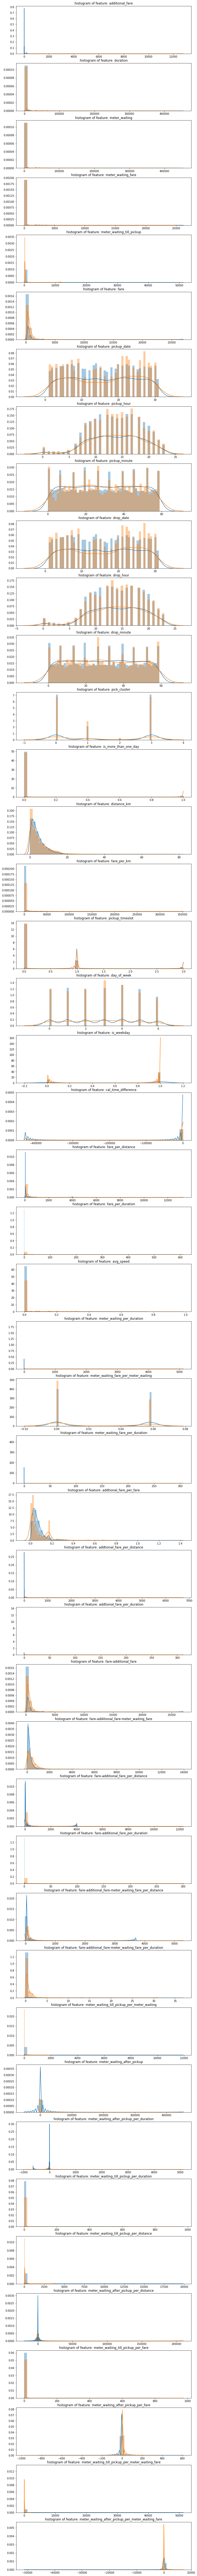

In [40]:
plt.figure(figsize=(12,45*4))
gs = gridspec.GridSpec(45, 1)
for i, cn in enumerate(train[features]):
    ax = plt.subplot(gs[i])
    sns.distplot(train[cn][train.label == 1], bins=50)
    sns.distplot(train[cn][train.label == 0], bins=50)
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(cn))
plt.show()

In [42]:
X = train_df[features]
Y = train_df['label']

In [46]:
def tsne_plot(x1, y1, name="graph.png",random_state=0):
    tsne = TSNE(n_components=2, random_state=random_state)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Correct')
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Incorrect')
    
    plt.legend(loc='best');
    plt.savefig(name);
    plt.show();
    

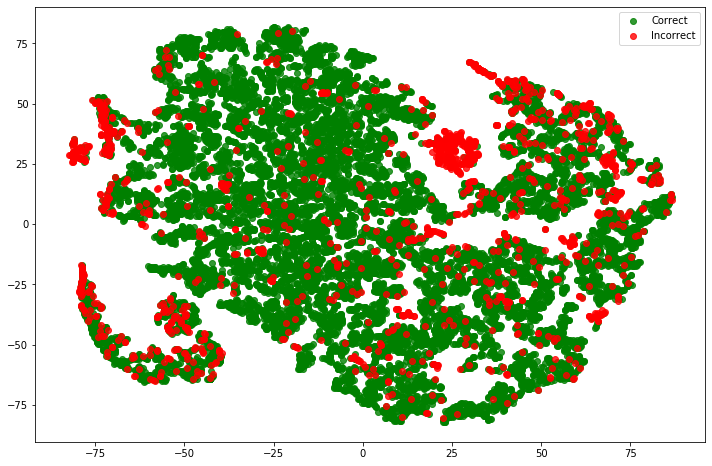

CPU times: user 10min 30s, sys: 8.66 s, total: 10min 39s
Wall time: 2min 46s


In [45]:
%%time
tsne_plot(X, Y, "original.png")

# Auto encoder

In [119]:
x_scale = MinMaxScaler().fit_transform(X)
x_correct, x_incorrect = x_scale[Y == 1], x_scale[Y == 0]

In [172]:
def get_model():
    ## input layer 
    input_layer = Input(shape=(X.shape[1],))

    ## encoding part
    encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
    encoded = Dense(50, activation='relu')(encoded)

    ## decoding part
    decoded = Dense(50, activation='tanh')(encoded)
    decoded = Dense(100, activation='tanh')(decoded)

    ## output layer
    output_layer = Dense(X.shape[1], activation='relu')(decoded)
    
    autoencoder = Model(input_layer, output_layer)
    autoencoder.compile(optimizer="adadelta", loss="mse")
    
    return autoencoder

In [127]:
def run_iterations(iterations,size=2000):
    autoencoder = get_model()
    autoencoder.fit(x_correct[:size], x_correct[:size], 
                    batch_size = 256, epochs = iterations, 
                    shuffle = True, validation_split = 0.20,verbose=False)
    
    hidden_representation = Sequential()
    hidden_representation.add(autoencoder.layers[0])
    hidden_representation.add(autoencoder.layers[1])
    hidden_representation.add(autoencoder.layers[2])
    
    correct_hid_rep = hidden_representation.predict(x_correct[:3000])
    incorrect_hid_rep = hidden_representation.predict(x_incorrect)
    
    rep_x = np.append(correct_hid_rep, incorrect_hid_rep, axis = 0)
    y_c = np.ones(correct_hid_rep.shape[0])
    y_i = np.zeros(incorrect_hid_rep.shape[0])
    rep_y = np.append(y_c, y_i)
    tsne_plot(rep_x, rep_y, f"latent_representation_{size}_{iterations}.png")

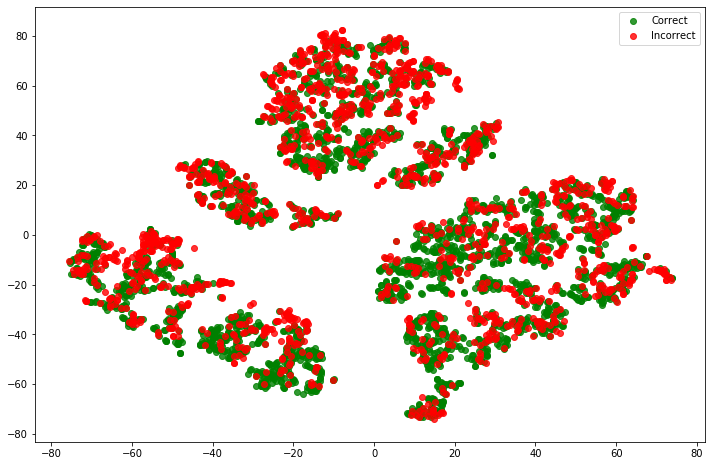

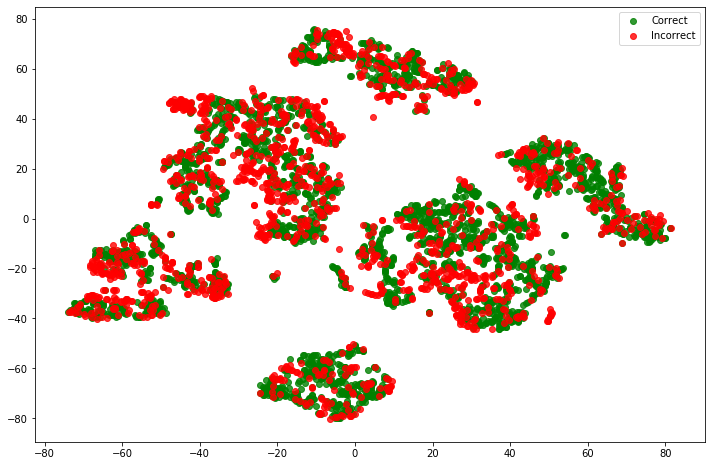

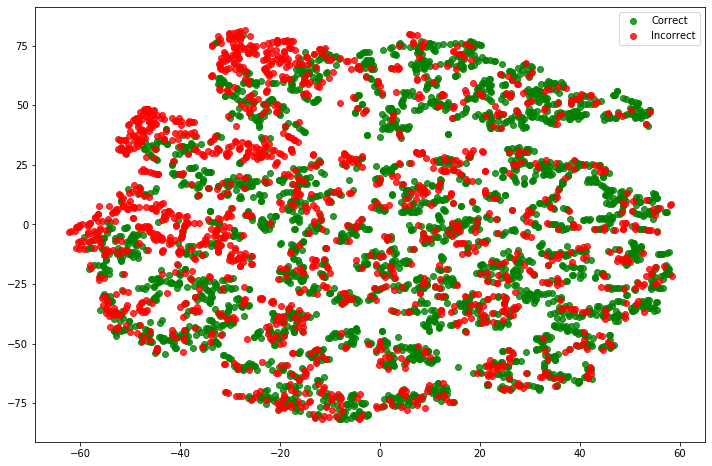

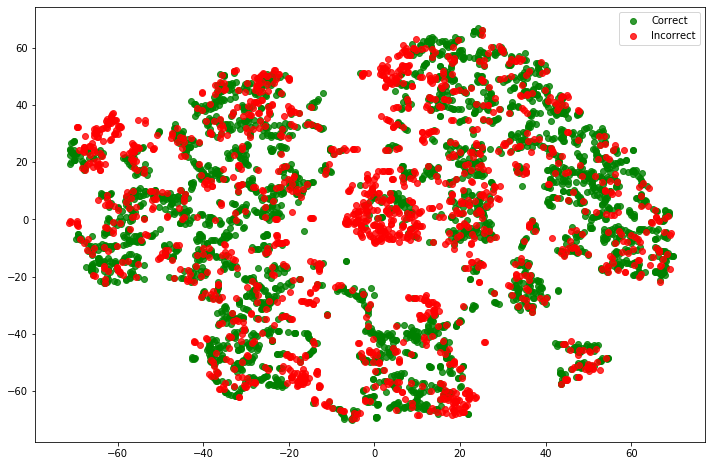

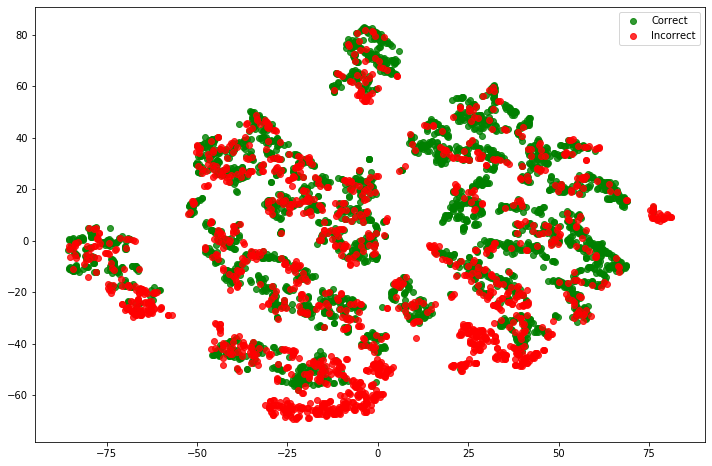

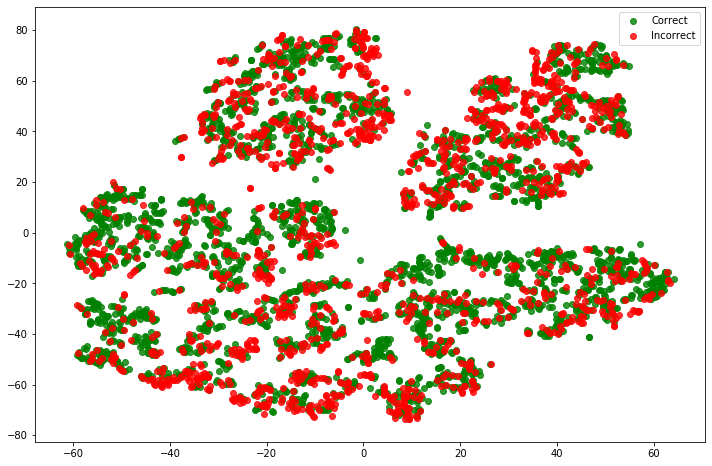

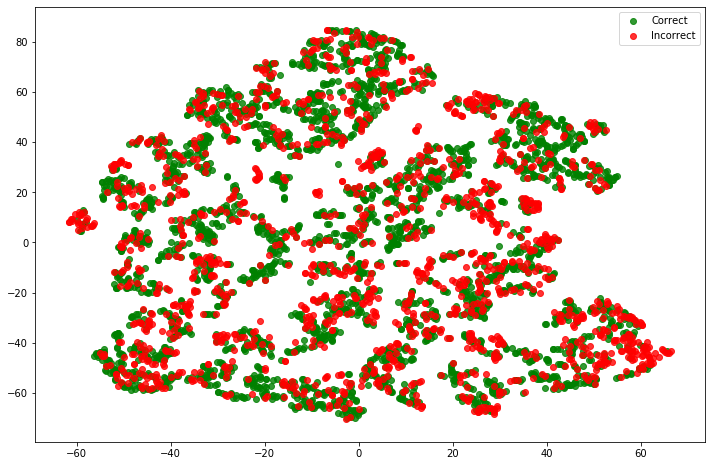

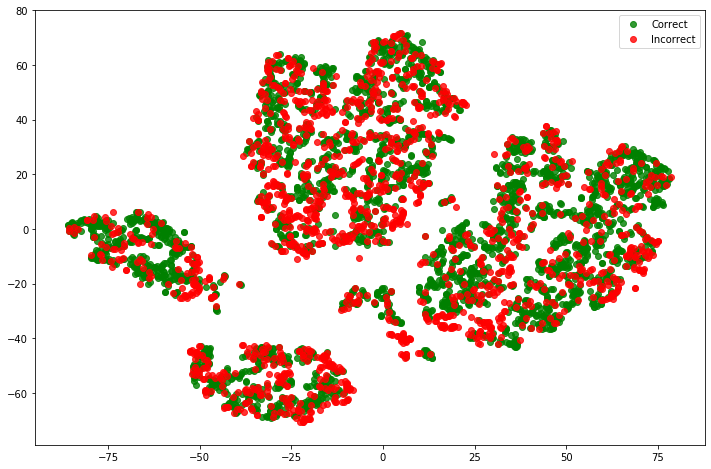

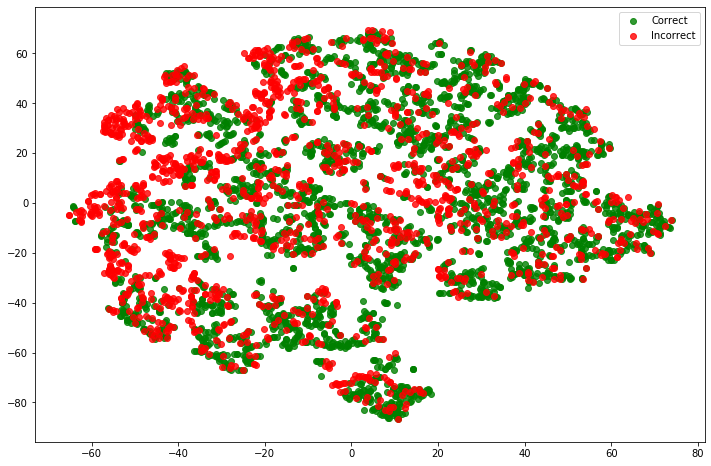

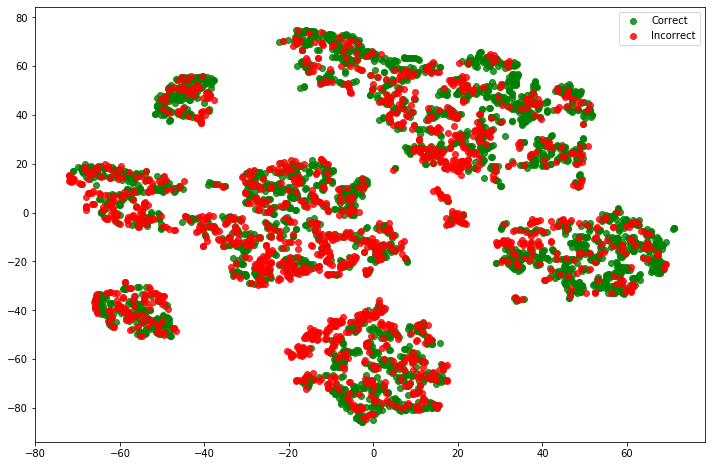

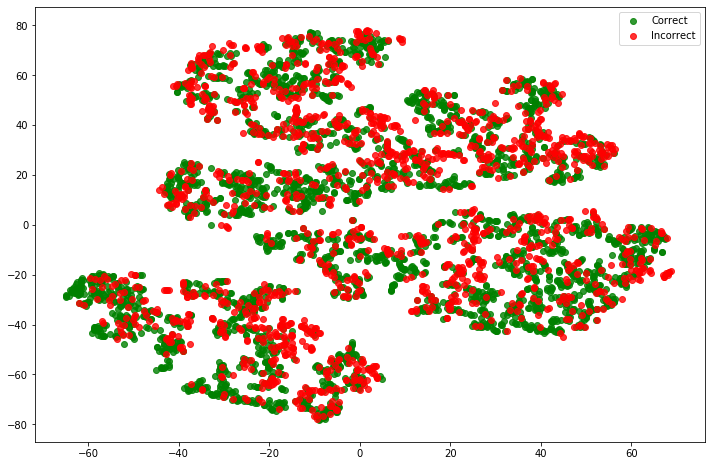

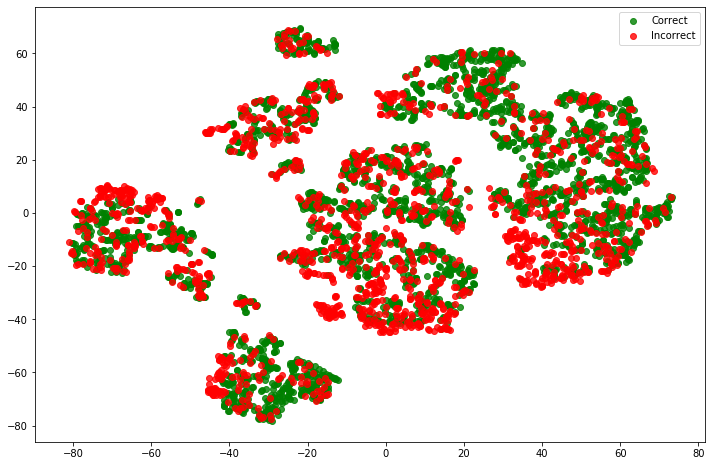

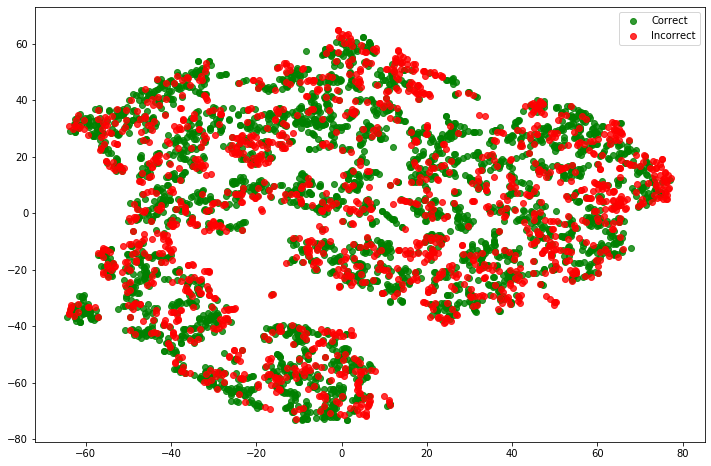

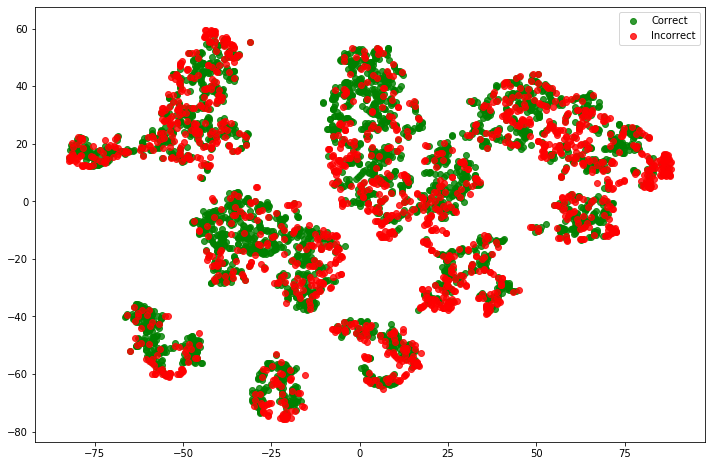

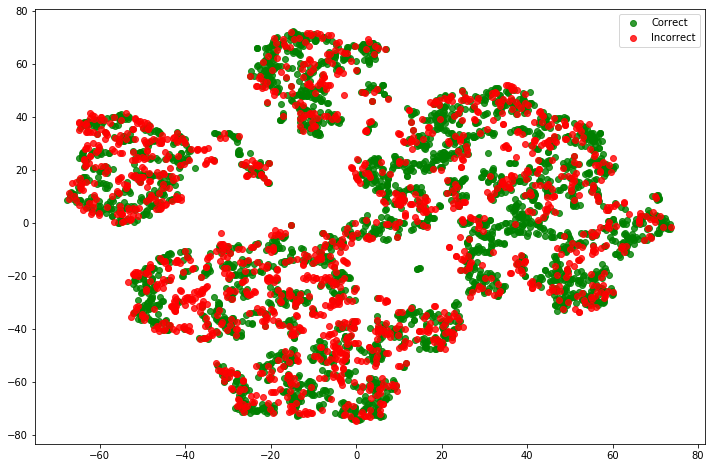

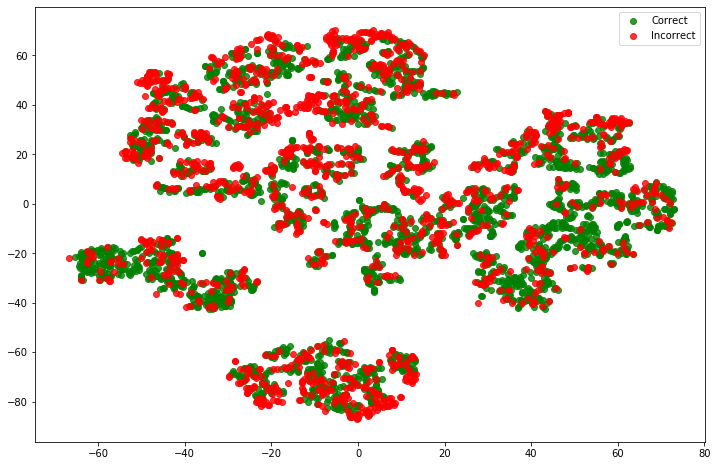

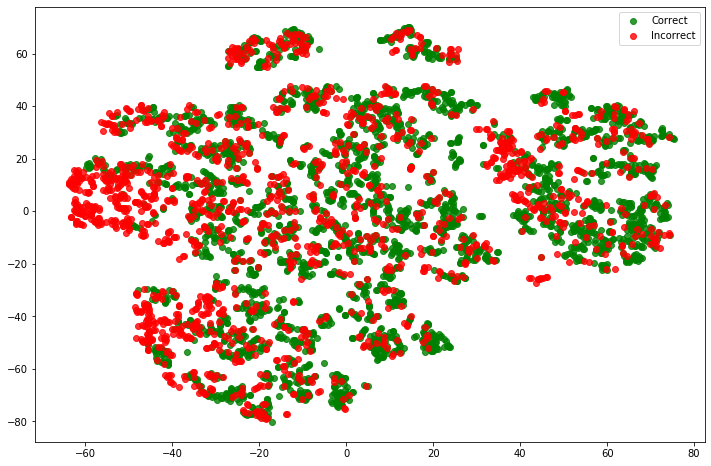

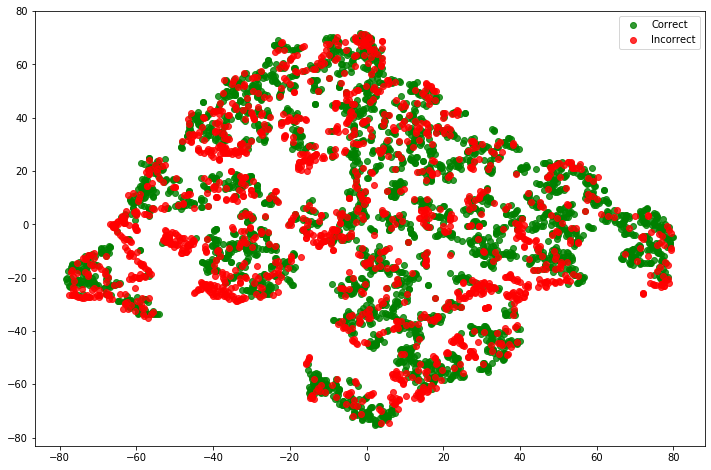

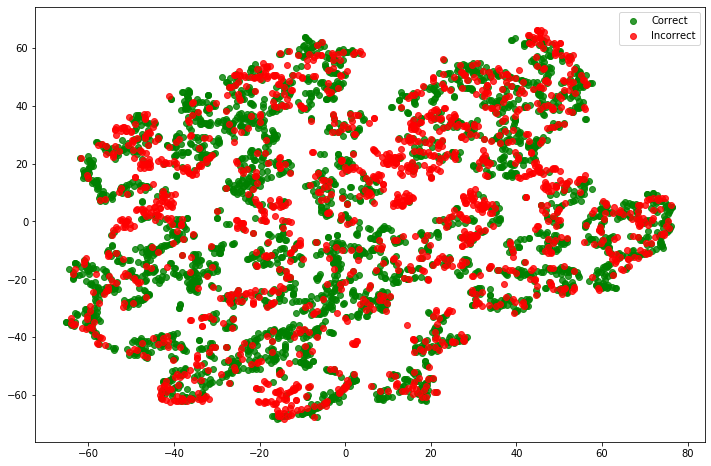

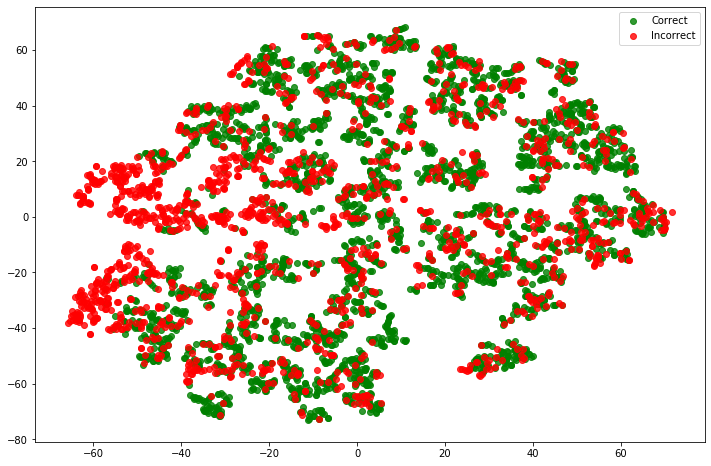

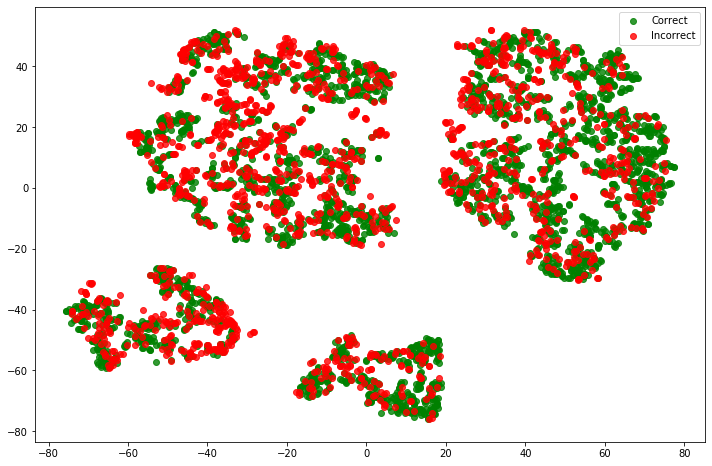

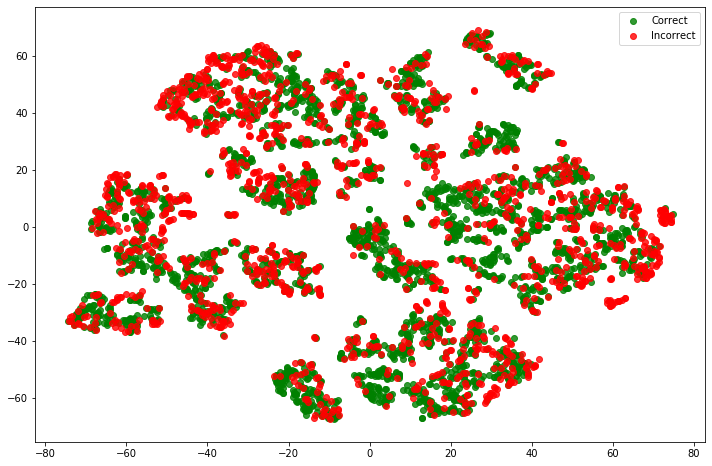

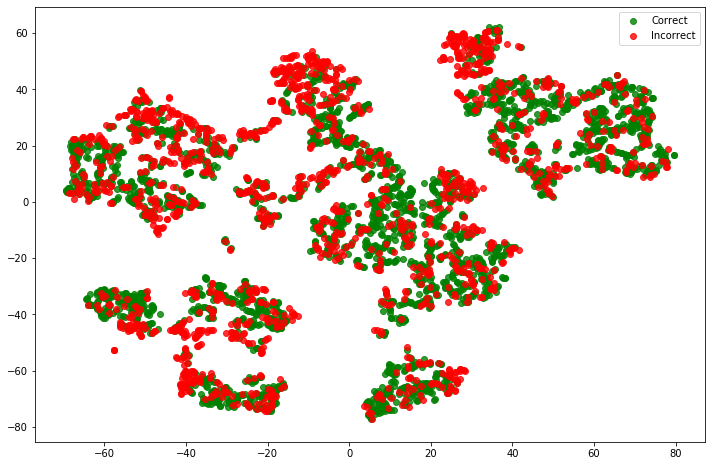

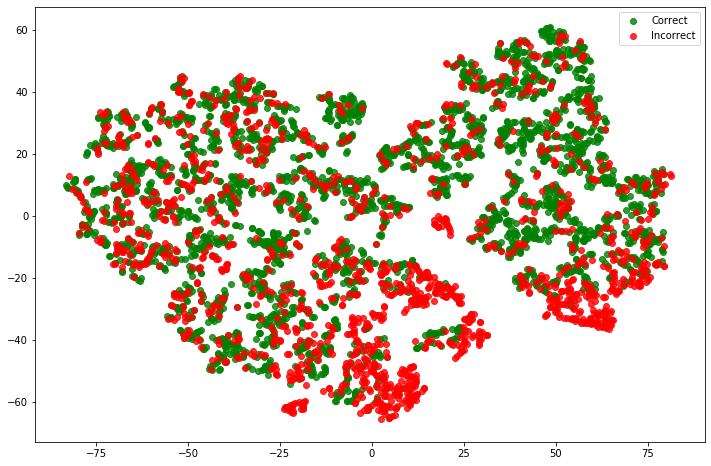

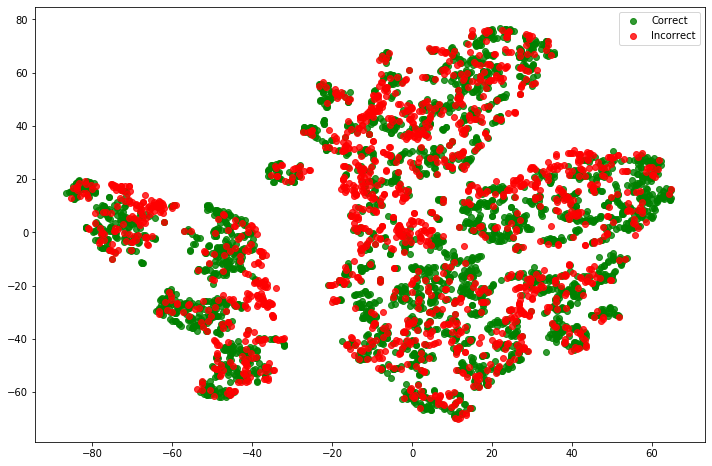

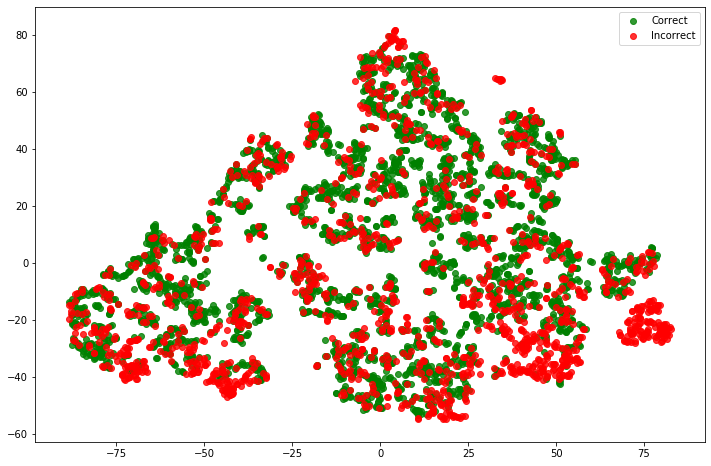

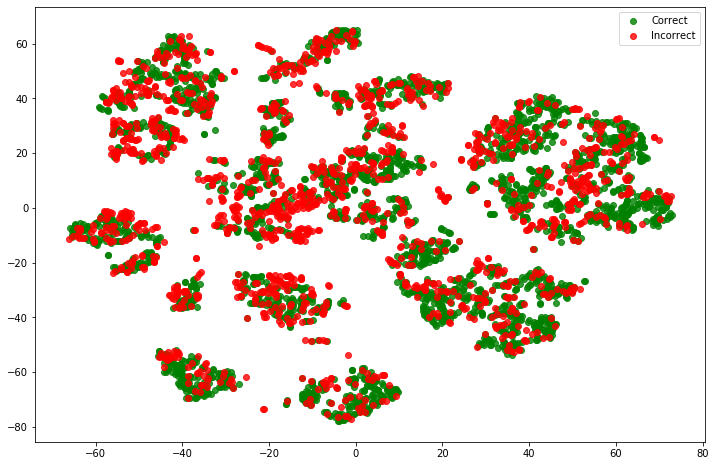

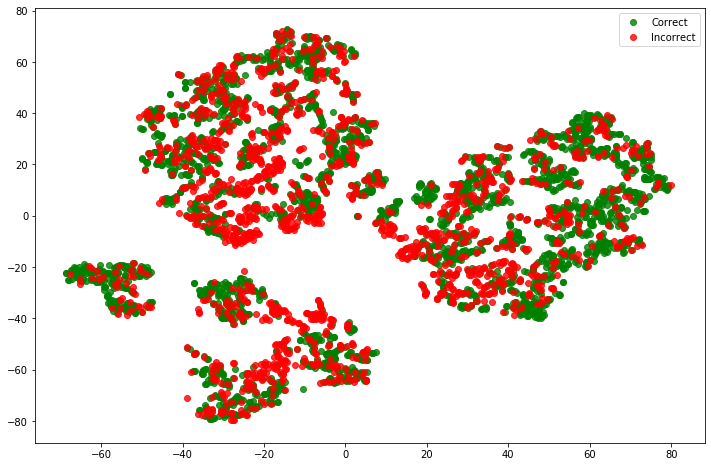

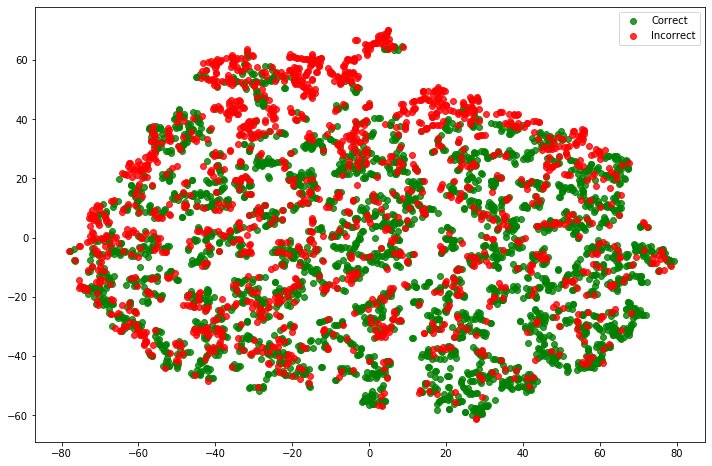

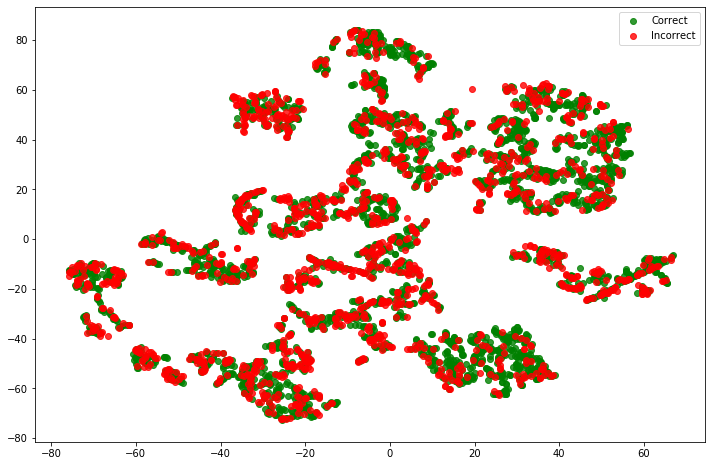

In [128]:
# for size in range(2_000,14_000,5_000):
#     for it in range(10,101,10):
#         run_iterations(it,size)

In [173]:
autoencoder = get_model()
autoencoder.fit(x_correct, x_correct, 
                batch_size = 256, epochs = 50, 
                shuffle = True, validation_split = 0.20,verbose=False)

In [174]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

In [175]:
correct_hid_rep = hidden_representation.predict(x_correct)
incorrect_hid_rep = hidden_representation.predict(x_incorrect)

In [176]:
rep_x = np.append(correct_hid_rep, incorrect_hid_rep, axis = 0)
y_c = np.ones(correct_hid_rep.shape[0])
y_i = np.zeros(incorrect_hid_rep.shape[0])
rep_y = np.append(y_c, y_i)

In [177]:
params = {
    'loss_function':'Logloss',
    'random_state':0,
    'early_stopping_rounds':50,
    'eval_metric':'F1',
#     'class_weights':class_weights
}

In [178]:
folds = 3
validation_scores = []
models = []

train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
skf = StratifiedKFold(n_splits=folds)
for train_index, test_index in skf.split(rep_x, rep_y):
    X_train, X_test = rep_x[train_index], rep_x[test_index]
    y_train, y_test = rep_y[train_index], rep_y[test_index]

    model = CatBoostClassifier(**params)
    model.fit(X=X_train,y=y_train,eval_set=(X_test,y_test),verbose=10)
    
    validation_score = model.best_score_['validation']['F1']
    print('Validation f1',validation_score)
    validation_scores.append(validation_score)
    models.append(model)

Learning rate set to 0.057693
0:	learn: 0.9529276	test: 0.9523986	best: 0.9523986 (0)	total: 16.2ms	remaining: 16.2s
10:	learn: 0.9529276	test: 0.9528835	best: 0.9528835 (1)	total: 153ms	remaining: 13.8s
20:	learn: 0.9529276	test: 0.9528835	best: 0.9528835 (1)	total: 251ms	remaining: 11.7s
30:	learn: 0.9529276	test: 0.9528835	best: 0.9528835 (1)	total: 328ms	remaining: 10.3s
40:	learn: 0.9531040	test: 0.9528835	best: 0.9528835 (1)	total: 404ms	remaining: 9.46s
50:	learn: 0.9532805	test: 0.9531481	best: 0.9531481 (49)	total: 497ms	remaining: 9.25s
60:	learn: 0.9537221	test: 0.9531481	best: 0.9531481 (49)	total: 573ms	remaining: 8.82s
70:	learn: 0.9540315	test: 0.9533247	best: 0.9533247 (68)	total: 650ms	remaining: 8.5s
80:	learn: 0.9542526	test: 0.9535013	best: 0.9535013 (76)	total: 739ms	remaining: 8.39s
90:	learn: 0.9543411	test: 0.9535896	best: 0.9535896 (81)	total: 817ms	remaining: 8.16s
100:	learn: 0.9544296	test: 0.9536780	best: 0.9536780 (93)	total: 895ms	remaining: 7.96s
110:	le

In [179]:
np.mean(validation_scores), np.std(validation_scores)

(0.9535698211005589, 0.00044330611292309576)